<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/Copy_of_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re


In [88]:
class VanillaNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    # The input features should be 6, matching the number of features extracted by loaddata.
    self.network = nn.Sequential(
        nn.Linear(6,24),
        nn.ReLU(),
        nn.Linear(24,36),

        nn.ReLU(),
        nn.Linear(36,1)
    )
  def forward(self, x):
       return self.network(x)

In [58]:
def train(dataloader, model, loss_fn, optimizer):

    model.train()
    train_loss = 0.0 # Initialize train_loss

    for X, y in dataloader:

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

        # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss # Return train_loss
    # print(f"Train Error: \n Avg loss: {train_loss:>8f} \n") # Removed print statement


In [78]:
def test(dataloader, model, loss_fn):

    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, y in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            all_preds.append(pred)
            all_targets.append(y)

    test_loss /= num_batches
    # Return test_loss, concatenated predictions, and concatenated targets
    return test_loss, torch.cat(all_preds), torch.cat(all_targets)

In [60]:
def read_labels(names_path):
    labels = []
    in_attr_section = False

    # Matches: "1. mpg: continuous"
    pat = re.compile(r"^\s*\d+\.\s*([^:]+)\s*:")

    with open(names_path, "r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()

            # Enter the attribute section
            if s.lower().startswith("7. attribute information"):
                in_attr_section = True
                continue

            # Once we're in the section, stop when the next numbered top-level section starts
            if in_attr_section and re.match(r"^\s*\d+\.\s+", s) and not pat.match(s):
                # This catches "8. Missing Attribute Values:" etc.
                break

            if in_attr_section:
                m = pat.match(s)
                if m:
                    name = m.group(1).strip()
                    labels.append(name)

    return labels


In [61]:
import numpy as np

def clean_data(datapath):
    """
    Parses auto-mpg.data robustly, then:
      - drops last column (car name)
      - drops any column that contains missing values (horsepower)
    Returns:
      clean numpy array with no NaNs
    """
    rows = []

    with open(datapath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Split into tokens. Car name may contain spaces, so only take first 8 as numeric.
            tokens = line.split()

            # Some lines might be malformed; skip if too short
            if len(tokens) < 8:
                continue

            num_tokens = tokens[:8]   # mpg, cyl, disp, hp, weight, accel, year, origin

            # Convert with missing value handling
            nums = []
            bad = False
            for t in num_tokens:
                if t == "?":
                    nums.append(np.nan)
                else:
                    try:
                        nums.append(float(t))
                    except ValueError:
                        bad = True
                        break

            if bad:
                continue

            rows.append(nums)

    data = np.array(rows, dtype=np.float32)

    # Drop columns with any NaN (this will drop horsepower)
    cols_with_nan = np.isnan(data).any(axis=0)
    data = data[:, ~cols_with_nan]

    # Safety: drop any remaining NaN rows (should be none after dropping cols)
    data = data[~np.isnan(data).any(axis=1)]

    return data




In [62]:
data = clean_data('/content/drive/MyDrive/Physics Informed ML/HW/auto_mpg/auto-mpg.data')
print(data)

[[ 18.    8.  307.  ...  12.   70.    1. ]
 [ 15.    8.  350.  ...  11.5  70.    1. ]
 [ 18.    8.  318.  ...  11.   70.    1. ]
 ...
 [ 32.    4.  135.  ...  11.6  82.    1. ]
 [ 28.    4.  120.  ...  18.6  82.    1. ]
 [ 31.    4.  119.  ...  19.4  82.    1. ]]


In [77]:
def normalize_data(data):
  #use standard normal distribution
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  normalized_data = (data - mean) / std
  # Return normalized data, and the mean and std for 'mpg' (first column)
  return normalized_data, mean[0], std[0]

normalized_data, mpg_mean, mpg_std = normalize_data(data)
print("Normalized data sample:", normalized_data[1])
print("Original data sample:", data[1])
print(f"MPG Mean: {mpg_mean}, MPG Std: {mpg_std}")

Normalized data sample: [-1.0907507   1.4981923   1.503514    0.85433334 -1.4770359  -1.6274277
 -0.7151456 ]
Original data sample: [1.500e+01 8.000e+00 3.500e+02 3.693e+03 1.150e+01 7.000e+01 1.000e+00]
MPG Mean: 23.51457405090332, MPG Std: 7.806159496307373


In [63]:
labels = read_labels('/content/drive/MyDrive/Physics Informed ML/HW/auto_mpg/auto-mpg.names')
labels = labels[:-2]
print(labels)

['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']


In [71]:
def loaddata(batch_size, labels, data):

  features = torch.tensor(data[:,1:], dtype=torch.float32)
  print(features.shape)
  targets = torch.tensor(data[:,0], dtype=torch.float32).reshape(-1,1)
  print(targets.shape)
  dataset = TensorDataset(features, targets)

  train_ds, test_ds = random_split(dataset, [0.8, 0.2])

  train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_ds, batch_size=batch_size)

  return train_dataloader, test_dataloader


torch.Size([398, 6])
torch.Size([398, 1])
Epoch 100: Train loss: 0.087728, Test loss: 0.083835
Epoch 200: Train loss: 0.068624, Test loss: 0.083545
Epoch 300: Train loss: 0.058710, Test loss: 0.084151
Epoch 400: Train loss: 0.049416, Test loss: 0.089987
Epoch 500: Train loss: 0.042470, Test loss: 0.097271
Epoch 600: Train loss: 0.037097, Test loss: 0.106131
Epoch 700: Train loss: 0.033081, Test loss: 0.108076
Epoch 800: Train loss: 0.031255, Test loss: 0.107245
Epoch 900: Train loss: 0.027647, Test loss: 0.109782
Epoch 1000: Train loss: 0.024069, Test loss: 0.113228
Done!


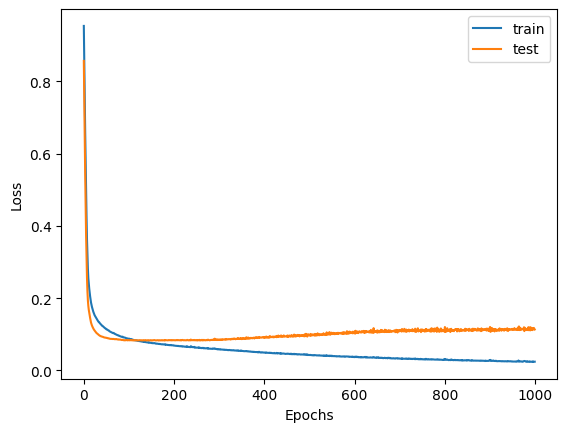

In [89]:

model = VanillaNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64

train_dataloader, test_dataloader = loaddata(batch_size, labels, normalized_data)

epochs = 1000
train_losses = []
test_losses = []



for e in range(epochs):
    # Removed print statement to avoid excessive output during long training
    # print(f"Epoch {e+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss_epoch, _, _ = test(test_dataloader, model, loss_fn) # Only need test_loss for plotting during epochs
    train_losses.append(train_loss)
    test_losses.append(test_loss_epoch)
    if (e + 1) % 100 == 0: # Print progress every 100 epochs
        print(f"Epoch {e+1}: Train loss: {train_loss:>8f}, Test loss: {test_loss_epoch:>8f}")
print("Done!")


plt.figure()
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), test_losses, label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [90]:

model.eval()

preds = []
targets = []

with torch.no_grad():
    for X, y in test_dataloader:
        y_hat = model(X)

        preds.append(y_hat.squeeze())
        targets.append(y.squeeze())

preds = torch.cat(preds)
targets = torch.cat(targets)

# -------------------------
# UN-NORMALIZE
# -------------------------
mpg_mean = 23.51457405090332
mpg_std  = 7.806159496307373

preds_mpg   = preds * mpg_std + mpg_mean
targets_mpg = targets * mpg_std + mpg_mean

# -------------------------
# MAE in MPG
# -------------------------
mae = torch.mean(torch.abs(preds_mpg - targets_mpg))

print(f"Test MAE: {mae.item():.3f} MPG")


Test MAE: 1.899 MPG
